# Obrada prirodnog jezika za razumijevanje povratnih informacija klijenata u ugostiteljskoj industriji

## Potrebni moduli

In [2]:
import re
from collections import Counter

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk import tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Učitavanje podataka

In [ ]:
# Za prikazivanje cijelih komentara
pd.set_option("max_colwidth", 100)

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/dsabljic/UUI-NLP-u-ugostiteljstvu/master/data/tripadvisor_hotel_reviews.csv')
df.head()

,Review,Rating
0,"nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took adv...",4
1,"ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle, sta...",2
2,nice rooms not 4* experience hotel monaco seattle good hotel n't 4* level.positives large bathro...,3
3,"unique, great stay, wonderful time hotel monaco, location excellent short stroll main downtown s...",5
4,"great stay great stay, went seahawk game awesome, downfall view building did n't complain, room ...",5


## EDA

In [ ]:
# Vrijednosti koje nedostaju
df.isna().sum()

Review    0
Rating    0
dtype: int64

In [ ]:
df.Rating.describe()

count    20491.000000
mean         3.952223
std          1.233030
min          1.000000
25%          3.000000
50%          4.000000
75%          5.000000
max          5.000000
Name: Rating, dtype: float64

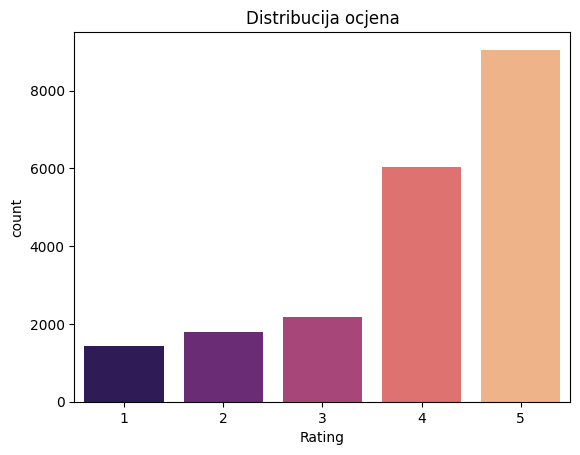

In [ ]:
# Distribucija ocjena
sns.countplot(data=df, x="Rating", palette="magma").set_title("Distribucija ocjena");

In [ ]:
# Duljina review-a (char)
df['Length'] = df['Review'].str.len()
df.head()

,Review,Rating,Length
0,nice hotel expensive parking got good deal sta...,4,593
1,ok nothing special charge diamond member hilto...,2,1689
2,nice rooms not 4* experience hotel monaco seat...,3,1427
3,"unique, great stay, wonderful time hotel monac...",5,600
4,"great stay great stay, went seahawk game aweso...",5,1281


In [ ]:
# Duljina review-a (riječ)
def word_count(review):
    review_list = review.split()
    return len(review_list)

df['Word count'] = df['Review'].apply(word_count)
df.head()

,Review,Rating,Length,Word count
0,nice hotel expensive parking got good deal sta...,4,593,87
1,ok nothing special charge diamond member hilto...,2,1689,250
2,nice rooms not 4* experience hotel monaco seat...,3,1427,217
3,"unique, great stay, wonderful time hotel monac...",5,600,89
4,"great stay great stay, went seahawk game aweso...",5,1281,191


In [ ]:
# Deskriptivna statistika
df.Length.describe()

count    20491.000000
mean       724.896833
std        689.101024
min         44.000000
25%        339.000000
50%        537.000000
75%        859.000000
max      13501.000000
Name: Length, dtype: float64

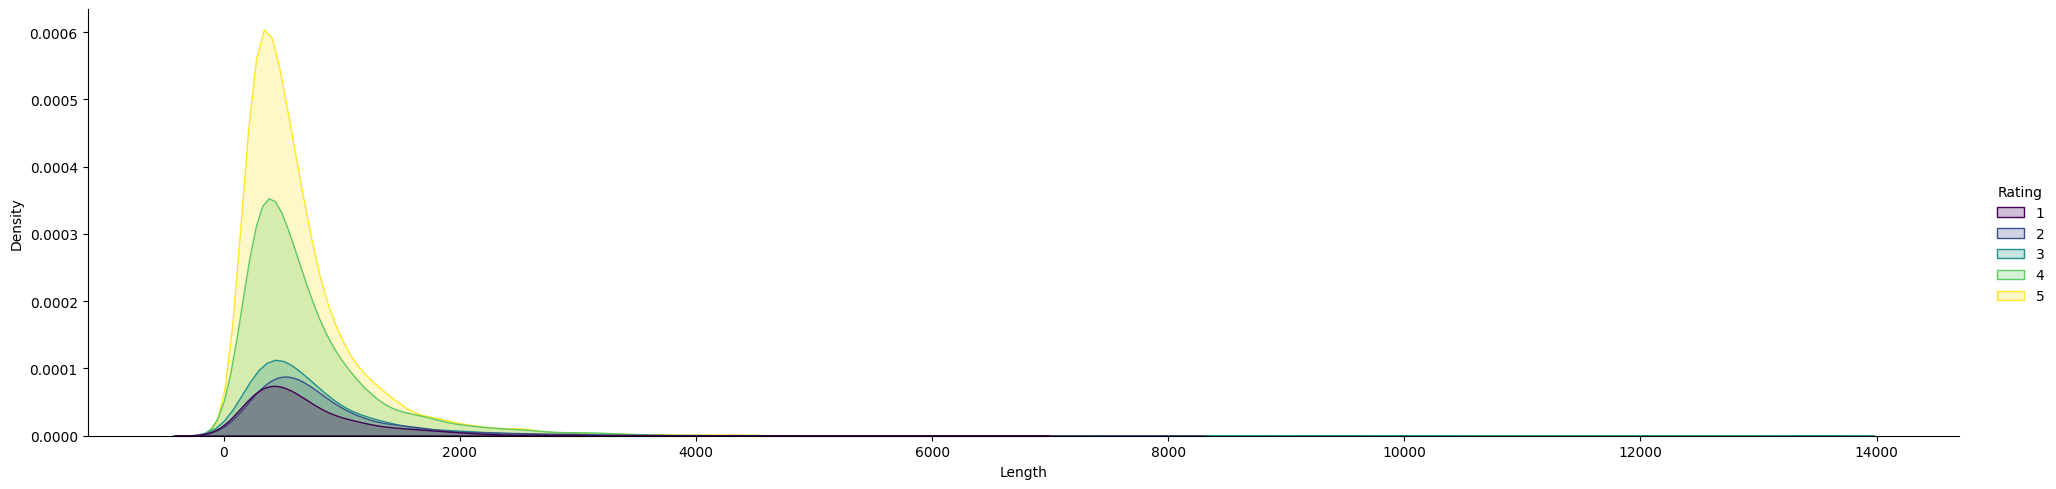

In [ ]:
sns.displot(data=df, x="Length", hue="Rating", palette="viridis", kind="kde", fill=True, aspect=4);

In [ ]:
df['Word count'].describe()

count    20491.000000
mean       104.375824
std        100.656586
min          7.000000
25%         48.000000
50%         77.000000
75%        124.000000
max       1931.000000
Name: Word count, dtype: float64

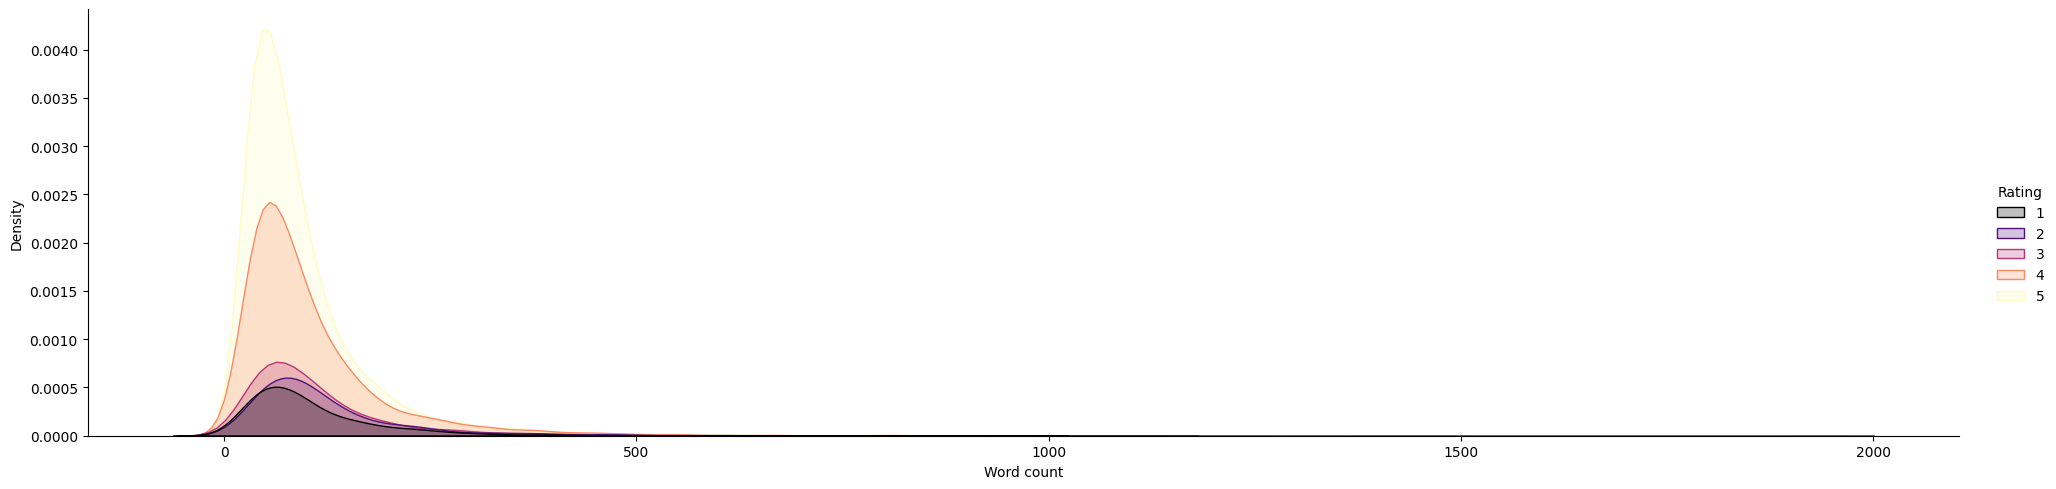

In [ ]:
sns.displot(data=df, x="Word count", hue="Rating", palette="magma", kind="kde", fill=True, aspect=4);

## Najzastupljenije riječi i *n*-grami

In [ ]:
df.drop(['Length', 'Word count'], axis = 1, inplace = True)
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [ ]:
def clean(review):

    review = review.lower()
    review = re.sub('[^a-z A-Z 0-9-]+', '', review) # uklanjanje specijalnih znakova
    review = " ".join([word for word in review.split() if word not in stopwords.words('english')])

    return review

In [ ]:
df['Review'] = df['Review'].apply(clean)

In [ ]:
def split_into_words(text):
    text_list = text.split()
    return text_list

df['Review_lists'] = df['Review'].apply(split_into_words)

In [ ]:
df.head()

,Review,Rating,Review_lists
0,nice hotel expensive parking got good deal sta...,4,"[nice, hotel, expensive, parking, got, good, d..."
1,ok nothing special charge diamond member hilto...,2,"[ok, nothing, special, charge, diamond, member..."
2,nice rooms 4 experience hotel monaco seattle g...,3,"[nice, rooms, 4, experience, hotel, monaco, se..."
3,unique great stay wonderful time hotel monaco ...,5,"[unique, great, stay, wonderful, time, hotel, ..."
4,great stay great stay went seahawk game awesom...,5,"[great, stay, great, stay, went, seahawk, game..."


In [ ]:
corpus = [word for review_list in df['Review_lists'] for word in review_list]
len(corpus)

2060911

In [ ]:
most_common_words = Counter(corpus).most_common(10)
most_common_words

[('hotel', 48844),
 ('room', 34279),
 ('great', 21068),
 ('nt', 18989),
 ('good', 16953),
 ('staff', 16193),
 ('stay', 15142),
 ('nice', 12393),
 ('rooms', 12005),
 ('location', 11009)]

In [ ]:
words, freq = zip(*most_common_words)

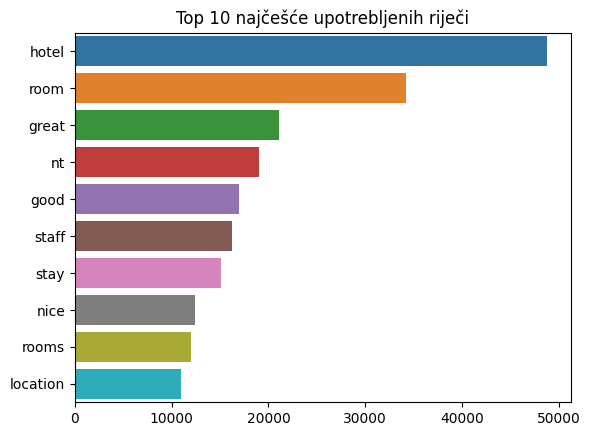

In [ ]:
sns.barplot(x=list(freq), y=list(words))
plt.title('Top 10 najčešće upotrebljenih riječi')
plt.show()

In [ ]:
def display_ngram(n, df):
  cv = CountVectorizer(ngram_range=(n,n))
  n_gram = cv.fit_transform(df['Review'])
  count_values = n_gram.toarray().sum(axis=0)
  ngram_df = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
  ngram_df.columns = ["frequency", "ngram"]

  sns.barplot(x=ngram_df['frequency'][:10], y=ngram_df['ngram'][:10])
  plt.title('Top 10 najčešćih n-grama')
  plt.show()

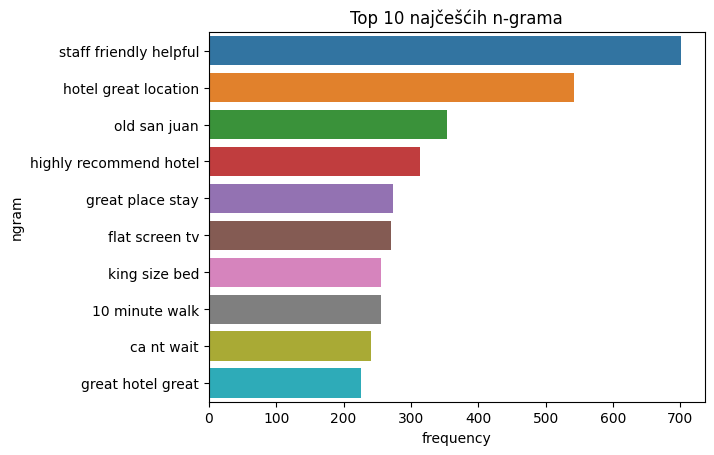

In [ ]:
n_gram = display_ngram(3, df)

## Analiza sentimenta sa sekvencijalnim modelima

// TODO
- ~~remove punctuation~~
- ~~GRU~~
- pre-trained embeddings
- BERT/RoBERTa

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Embedding, SimpleRNN, GRU, Dense, Dropout, TextVectorization
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split

from nltk.stem.snowball import SnowballStemmer

In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/dsabljic/UUI-NLP-u-ugostiteljstvu/master/data/tripadvisor_hotel_reviews.csv')
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [6]:
df['Label'] = df['Rating'].apply(lambda x: 0 if x in [1, 2] else (1 if x == 3 else 2))

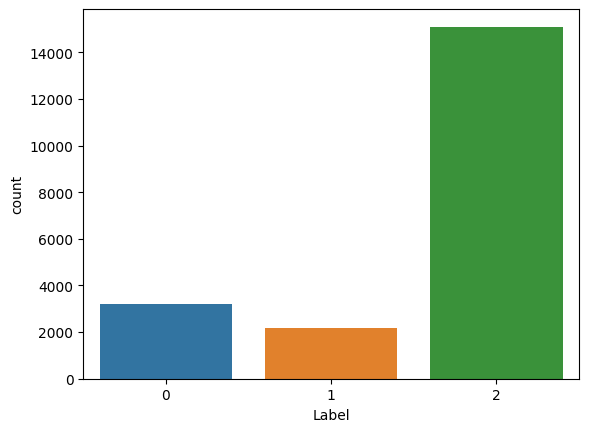

In [7]:
sns.countplot(x='Label', data=df);

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df["Review"], df["Label"], test_size=0.2, random_state=72)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=72)

In [9]:
# Definirajte stopwords i izuzmite one koji utječu na sentiment
stop_words = set(stopwords.words('english'))
words_to_keep = {'not', 'no', 'nt', 'very', 'really'}
filtered_stop_words = stop_words - words_to_keep

stemmer = SnowballStemmer("english")

def custom_preprocessing_sw_removal(text):
    # Uklanjanje interpunkcije
    text = re.sub(r'[^\w\s]', '', text)
    # Stemming i uklanjanje stopwordsa osim onih koji utječu na sentiment
    text = " ".join(stemmer.stem(word) for word in text.split() if word not in filtered_stop_words)

    return text

In [10]:
X_train = X_train.apply(custom_preprocessing_sw_removal)
X_val = X_val.apply(custom_preprocessing_sw_removal)
X_test = X_test.apply(custom_preprocessing_sw_removal)

In [11]:
batch_size = 32
VOCAB_TOKENS = 5000

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(X_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_TOKENS)

encoder.adapt(train_ds.map(lambda text, labels: text))

np.array(encoder.get_vocabulary())[:20]

array(['', '[UNK]', 'hotel', 'room', 'not', 'stay', 'great', 'nt', 'good',
       'staff', 'night', 'locat', 'nice', 'day', 'time', 'no', 'servic',
       'clean', 'walk', 'restaur'], dtype='<U14')

In [12]:
def plot_metrics(history):
    metrics = pd.DataFrame(history.history)
    metrics[['accuracy', 'val_accuracy']].plot()
    metrics[['loss', 'val_loss']].plot()

### *Vanilla* RNN

Epoch 1/10
385/385 [==============================] - 300s 774ms/step - loss: 0.7738 - accuracy: 0.7190 - val_loss: 0.6283 - val_accuracy: 0.8114
Epoch 2/10
385/385 [==============================] - 276s 718ms/step - loss: 0.5179 - accuracy: 0.8291 - val_loss: 0.4575 - val_accuracy: 0.8421
Epoch 3/10
385/385 [==============================] - 267s 692ms/step - loss: 0.4191 - accuracy: 0.8576 - val_loss: 0.4500 - val_accuracy: 0.8470
Epoch 4/10
385/385 [==============================] - 265s 688ms/step - loss: 0.3792 - accuracy: 0.8644 - val_loss: 0.6059 - val_accuracy: 0.7694
Epoch 5/10
385/385 [==============================] - 265s 686ms/step - loss: 0.3103 - accuracy: 0.8841 - val_loss: 0.4593 - val_accuracy: 0.8394
Epoch 6/10
385/385 [==============================] - 265s 689ms/step - loss: 0.2247 - accuracy: 0.9212 - val_loss: 0.4946 - val_accuracy: 0.8348

Final val_accuracy: 83.48%



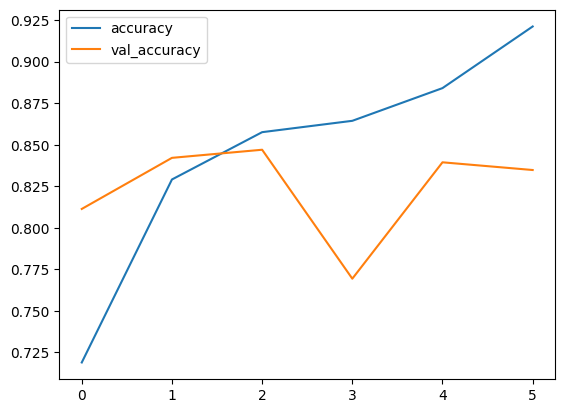

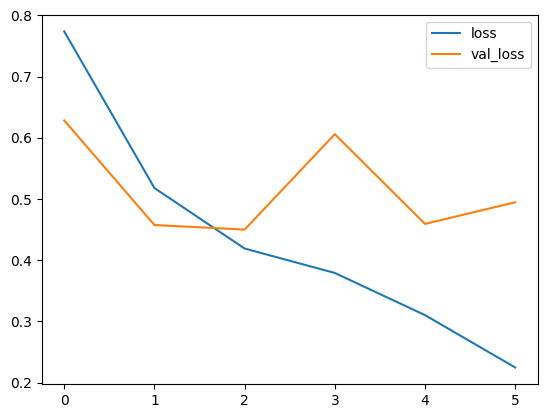

In [13]:
rnn_model = tf.keras.models.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 50, mask_zero = True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')])

rnn_model.compile(optimizer=Adam(learning_rate=3e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = rnn_model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, monitor="val_accuracy")])
print(f"\nFinal val_accuracy: {history.history['val_accuracy'][-1]:.2%}\n")

plot_metrics(history)

In [17]:
test_loss, test_acc = rnn_model.evaluate(test_ds)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

129/129 [==============================] - 9s 72ms/step - loss: 0.5015 - accuracy: 0.8351
Test Loss: 0.5014588236808777
Test Accuracy: 0.8350817561149597


### GRU

Epoch 1/10
385/385 [==============================] - 43s 101ms/step - loss: 0.9395 - accuracy: 0.7600 - val_loss: 0.5574 - val_accuracy: 0.8245
Epoch 2/10
385/385 [==============================] - 23s 59ms/step - loss: 0.5334 - accuracy: 0.8324 - val_loss: 0.5074 - val_accuracy: 0.8360
Epoch 3/10
385/385 [==============================] - 19s 48ms/step - loss: 0.4704 - accuracy: 0.8530 - val_loss: 0.4851 - val_accuracy: 0.8341
Epoch 4/10
385/385 [==============================] - 15s 40ms/step - loss: 0.4331 - accuracy: 0.8554 - val_loss: 0.5185 - val_accuracy: 0.8433
Epoch 5/10
385/385 [==============================] - 13s 33ms/step - loss: 0.4045 - accuracy: 0.8654 - val_loss: 0.4692 - val_accuracy: 0.8402
Epoch 6/10
385/385 [==============================] - 13s 34ms/step - loss: 0.3696 - accuracy: 0.8767 - val_loss: 0.4826 - val_accuracy: 0.8289
Epoch 7/10
385/385 [==============================] - 12s 30ms/step - loss: 0.3414 - accuracy: 0.8850 - val_loss: 0.5385 - val_accuracy

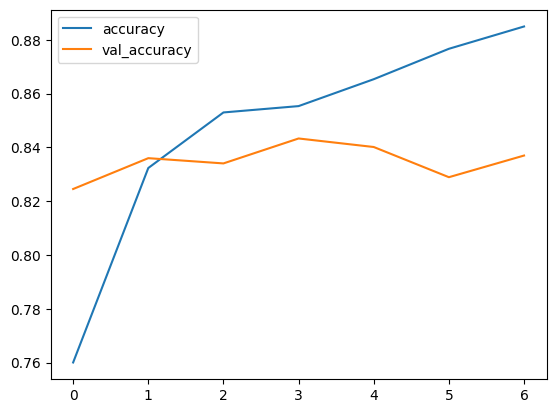

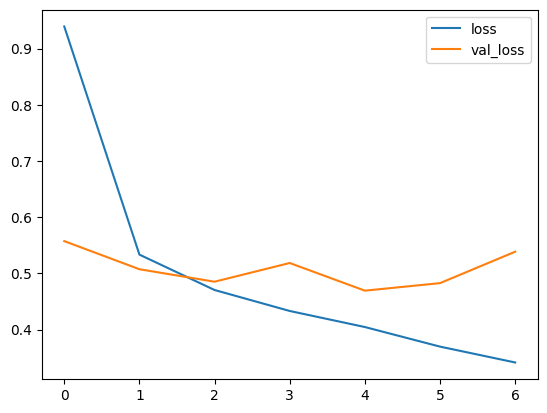

In [17]:
gru_model1 = tf.keras.models.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 50, mask_zero = True),
    tf.keras.layers.GRU(32),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.005)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')])

gru_model1.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = gru_model1.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, monitor="val_accuracy")])
print(f"\nFinal val_accuracy: {history.history['val_accuracy'][-1]:.2%}\n")

plot_metrics(history)

In [18]:
test_loss, test_acc = gru_model1.evaluate(test_ds)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

129/129 [==============================] - 1s 10ms/step - loss: 0.5241 - accuracy: 0.8370
Test Loss: 0.5240968465805054
Test Accuracy: 0.8370334506034851


## Dvosmjerna GRU mreža

Epoch 1/10
385/385 [==============================] - 54s 120ms/step - loss: 0.9623 - accuracy: 0.7895 - val_loss: 0.5107 - val_accuracy: 0.8324
Epoch 2/10
385/385 [==============================] - 30s 78ms/step - loss: 0.4721 - accuracy: 0.8544 - val_loss: 0.4639 - val_accuracy: 0.8389
Epoch 3/10
385/385 [==============================] - 24s 61ms/step - loss: 0.4013 - accuracy: 0.8702 - val_loss: 0.4328 - val_accuracy: 0.8538
Epoch 4/10
385/385 [==============================] - 20s 53ms/step - loss: 0.3561 - accuracy: 0.8838 - val_loss: 0.5000 - val_accuracy: 0.8529
Epoch 5/10
385/385 [==============================] - 19s 49ms/step - loss: 0.3236 - accuracy: 0.8983 - val_loss: 0.4472 - val_accuracy: 0.8546
Epoch 6/10
385/385 [==============================] - 19s 50ms/step - loss: 0.2944 - accuracy: 0.9091 - val_loss: 0.4593 - val_accuracy: 0.8494
Epoch 7/10
385/385 [==============================] - 18s 47ms/step - loss: 0.2672 - accuracy: 0.9233 - val_loss: 0.4883 - val_accuracy

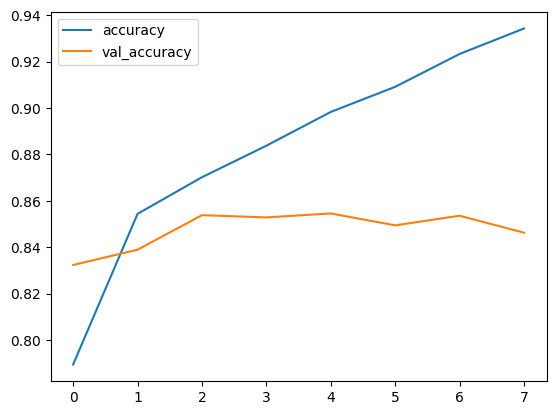

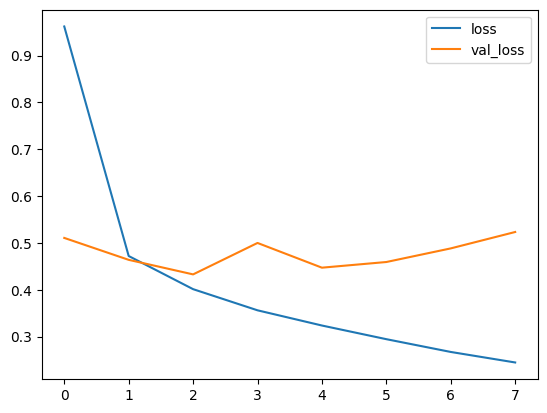

In [30]:
bi_gru_model = tf.keras.models.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 50, mask_zero = True),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.005)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(3, activation='softmax')])

bi_gru_model.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = bi_gru_model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, monitor="val_accuracy")])
print(f"\nFinal val_accuracy: {history.history['val_accuracy'][-1]:.2%}\n")

plot_metrics(history)

In [31]:
test_loss, test_acc = bi_gru_model.evaluate(test_ds)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

129/129 [==============================] - 3s 21ms/step - loss: 0.5351 - accuracy: 0.8431
Test Loss: 0.5350672602653503
Test Accuracy: 0.843132495880127


## LSTM

Epoch 1/10
385/385 [==============================] - 44s 99ms/step - loss: 1.0009 - accuracy: 0.7803 - val_loss: 0.6218 - val_accuracy: 0.7338
Epoch 2/10
385/385 [==============================] - 25s 66ms/step - loss: 0.5924 - accuracy: 0.7574 - val_loss: 0.5514 - val_accuracy: 0.7667
Epoch 3/10
385/385 [==============================] - 17s 44ms/step - loss: 0.5384 - accuracy: 0.7965 - val_loss: 0.6446 - val_accuracy: 0.7457
Epoch 4/10
385/385 [==============================] - 14s 37ms/step - loss: 0.4989 - accuracy: 0.8353 - val_loss: 0.5201 - val_accuracy: 0.8165
Epoch 5/10
385/385 [==============================] - 14s 37ms/step - loss: 0.4411 - accuracy: 0.8580 - val_loss: 0.4854 - val_accuracy: 0.8414
Epoch 6/10
385/385 [==============================] - 13s 34ms/step - loss: 0.4139 - accuracy: 0.8638 - val_loss: 0.4573 - val_accuracy: 0.8460
Epoch 7/10
385/385 [==============================] - 11s 29ms/step - loss: 0.3712 - accuracy: 0.8773 - val_loss: 0.4822 - val_accuracy:

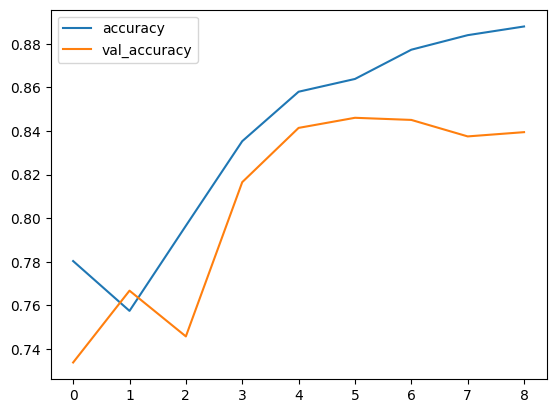

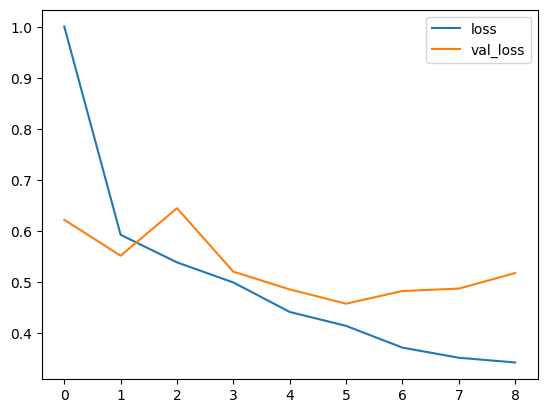

In [14]:
lstm_model = tf.keras.models.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 50, mask_zero = True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.005)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')])

lstm_model.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = lstm_model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, monitor="val_accuracy")])
print(f"\nFinal val_accuracy: {history.history['val_accuracy'][-1]:.2%}\n")

plot_metrics(history)

In [19]:
test_loss, test_acc = lstm_model.evaluate(test_ds)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

129/129 [==============================] - 1s 10ms/step - loss: 0.5250 - accuracy: 0.8370
Test Loss: 0.5249595046043396
Test Accuracy: 0.8370334506034851


Epoch 1/10
385/385 [==============================] - 71s 159ms/step - loss: 1.0137 - accuracy: 0.7831 - val_loss: 0.9179 - val_accuracy: 0.5754
Epoch 2/10
385/385 [==============================] - 29s 75ms/step - loss: 0.5426 - accuracy: 0.8253 - val_loss: 0.4940 - val_accuracy: 0.8324
Epoch 3/10
385/385 [==============================] - 24s 62ms/step - loss: 0.4627 - accuracy: 0.8523 - val_loss: 0.4671 - val_accuracy: 0.8463
Epoch 4/10
385/385 [==============================] - 23s 59ms/step - loss: 0.4281 - accuracy: 0.8599 - val_loss: 0.4655 - val_accuracy: 0.8419
Epoch 5/10
385/385 [==============================] - 19s 49ms/step - loss: 0.4068 - accuracy: 0.8658 - val_loss: 0.4983 - val_accuracy: 0.8399
Epoch 6/10
385/385 [==============================] - 18s 48ms/step - loss: 0.3659 - accuracy: 0.8795 - val_loss: 0.4653 - val_accuracy: 0.8519
Epoch 7/10
385/385 [==============================] - 19s 50ms/step - loss: 0.3447 - accuracy: 0.8892 - val_loss: 0.5226 - val_accuracy

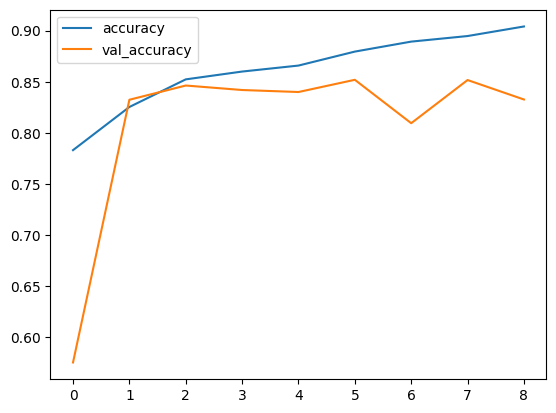

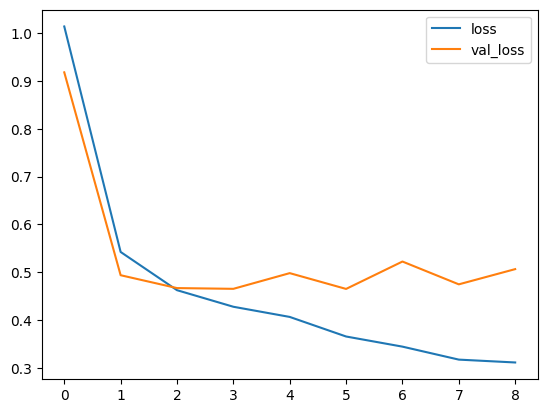

In [15]:
bi_lstm_model = tf.keras.models.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 50, mask_zero = True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.005)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')])

bi_lstm_model.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = bi_lstm_model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, monitor="val_accuracy")])
print(f"\nFinal val_accuracy: {history.history['val_accuracy'][-1]:.2%}\n")

plot_metrics(history)

In [16]:
test_loss, test_acc = bi_lstm_model.evaluate(test_ds)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

129/129 [==============================] - 2s 17ms/step - loss: 0.5105 - accuracy: 0.8356
Test Loss: 0.510464608669281
Test Accuracy: 0.8355696797370911


## GloVe

In [ ]:
!wget https://nlp.stanford.edu/data/glove.6B.zip

--2024-01-09 21:40:14--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-01-09 21:40:14--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.08MB/s    in 2m 39s  

2024-01-09 21:42:53 (5.18 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [ ]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
glove_path = './glove.6B.100d.txt'

embeddings_index = {}
with open(glove_path, 'r', encoding='utf8') as file:
    for line in file:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vector

In [ ]:
vocab = encoder.get_vocabulary()
embedding_dim = 100
embedding_matrix = np.zeros((len(vocab), embedding_dim))

for i, word in enumerate(vocab):
    if word in embeddings_index:
        embedding_matrix[i] = embeddings_index[word]
    else:
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim, ))

embedding_layer = tf.keras.layers.Embedding(
    input_dim=len(vocab),
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    trainable=False
)

Epoch 1/10
385/385 [==============================] - 17s 35ms/step - loss: 0.6215 - accuracy: 0.7661 - val_loss: 0.5166 - val_accuracy: 0.8011
Epoch 2/10
385/385 [==============================] - 12s 31ms/step - loss: 0.4793 - accuracy: 0.8197 - val_loss: 0.4254 - val_accuracy: 0.8355
Epoch 3/10
385/385 [==============================] - 12s 31ms/step - loss: 0.4049 - accuracy: 0.8483 - val_loss: 0.4864 - val_accuracy: 0.8243
Epoch 4/10
385/385 [==============================] - 13s 33ms/step - loss: 0.3734 - accuracy: 0.8599 - val_loss: 0.4007 - val_accuracy: 0.8529
Epoch 5/10
385/385 [==============================] - 12s 32ms/step - loss: 0.3406 - accuracy: 0.8694 - val_loss: 0.4133 - val_accuracy: 0.8416
Epoch 6/10
385/385 [==============================] - 13s 33ms/step - loss: 0.3209 - accuracy: 0.8753 - val_loss: 0.3882 - val_accuracy: 0.8594
Epoch 7/10
385/385 [==============================] - 12s 32ms/step - loss: 0.2911 - accuracy: 0.8865 - val_loss: 0.4001 - val_accuracy:

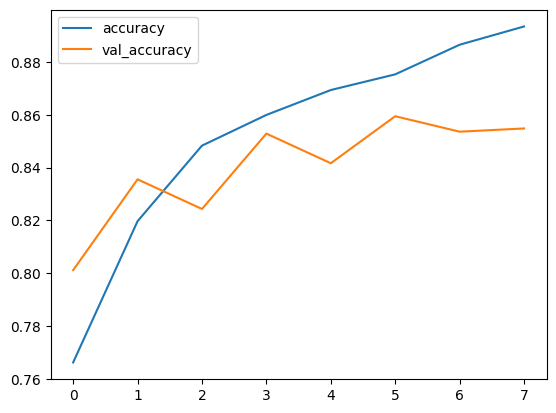

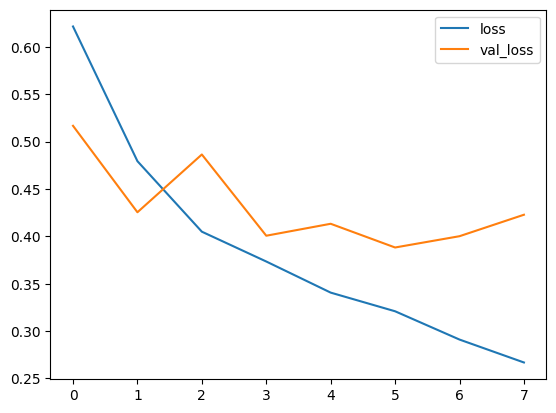

In [ ]:
gru_model_glove6 = tf.keras.models.Sequential([
    encoder,
    embedding_layer,
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(3, activation='softmax')])

gru_model_glove6.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = gru_model_glove6.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, monitor="val_accuracy")])
print(f"\nFinal val_accuracy: {history.history['val_accuracy'][-1]:.2%}\n")

plot_metrics(history)

In [ ]:
test_loss, test_acc = gru_model_glove6.evaluate(test_ds)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

129/129 [==============================] - 2s 14ms/step - loss: 0.3928 - accuracy: 0.8561
Test Loss: 0.39279043674468994
Test Accuracy: 0.8560624718666077
